激活函数主要是为了实现神经网络学习输入和输出之间的复杂非线性关系而使用的一个函数。在公式 (1) 中，ReLU 是一个激活函数（Transfromers原版），可以替换成其他的激活函数，比如 BERT 开始用 Gaussian Error Linear Unit，GELU 比较多，随后就成了激活函数的主流选择，但是随着大模型的爆火以及 PaLM 模型的发布，大家开始慢慢使用 swishGLU 作为激活函数，并且作为一个主要的优化点。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            # 激活函数
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )

    def forward(self, x):
        return self.net(x)

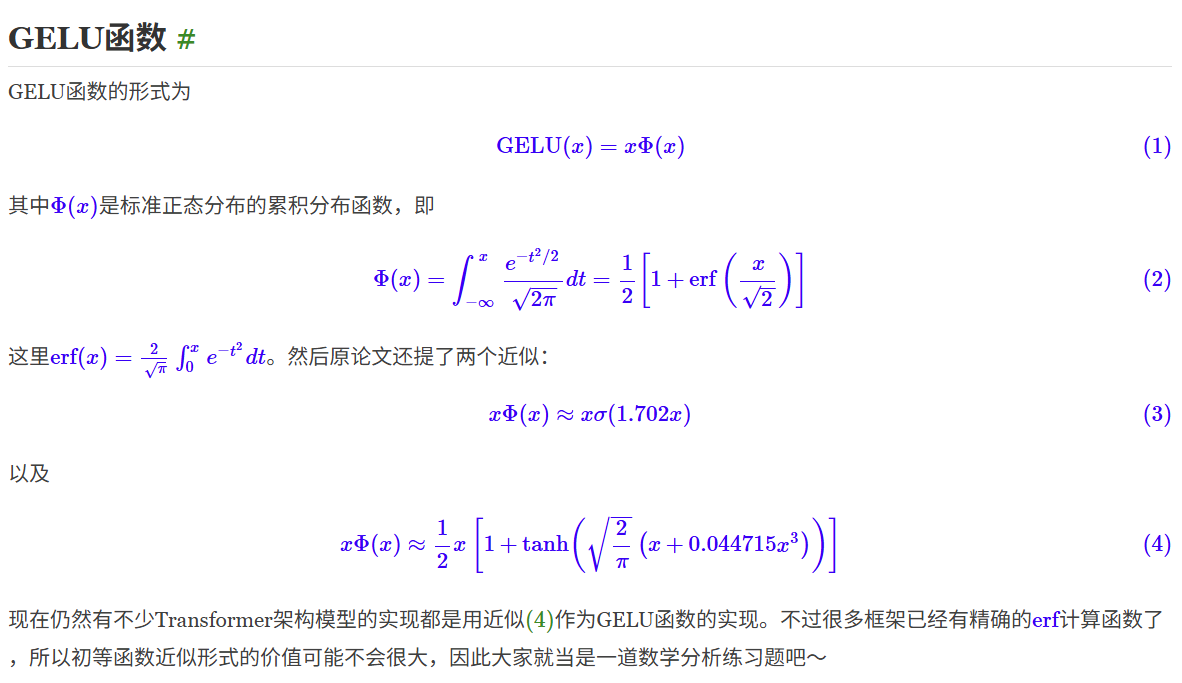

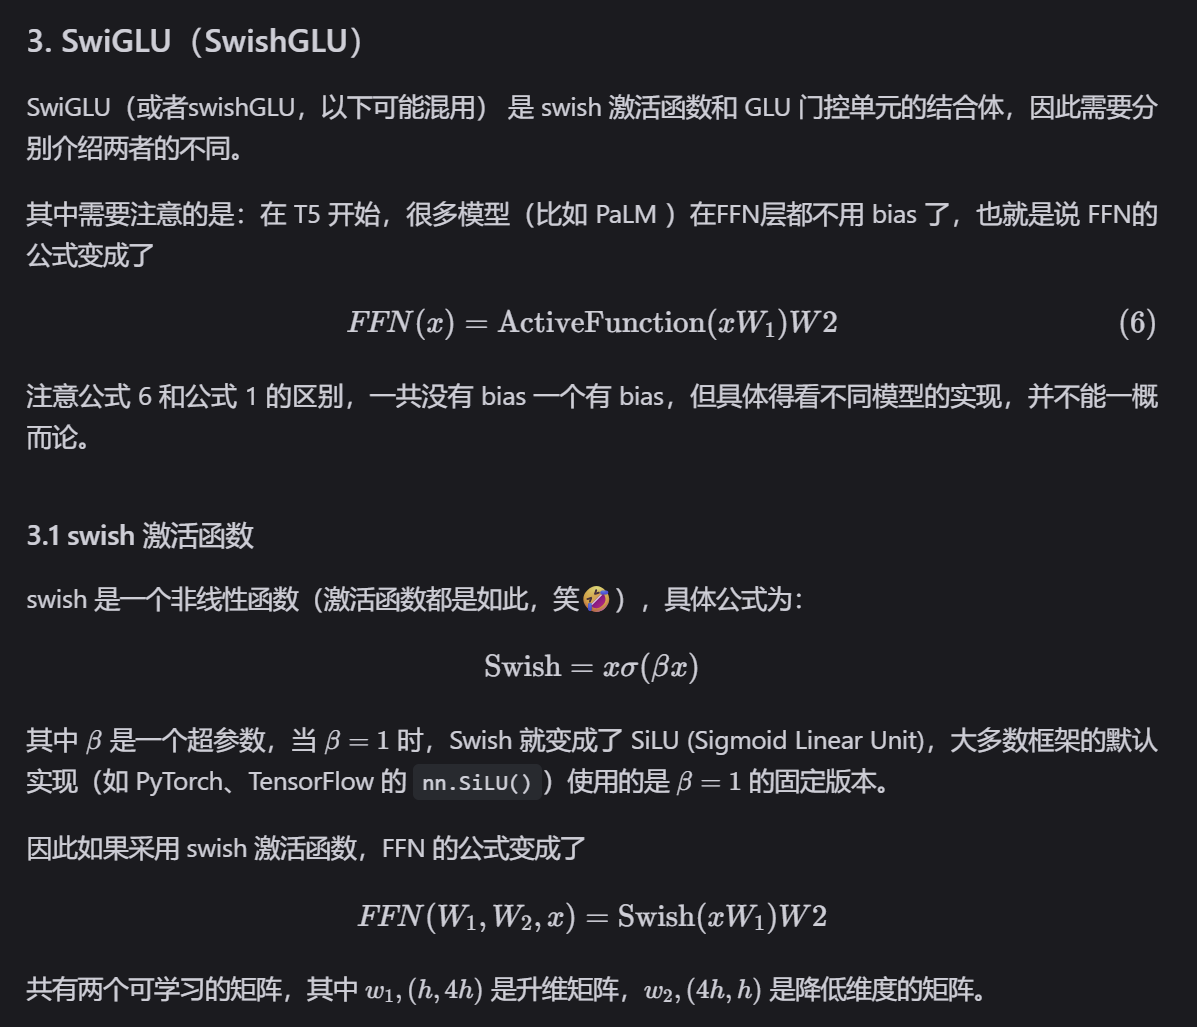

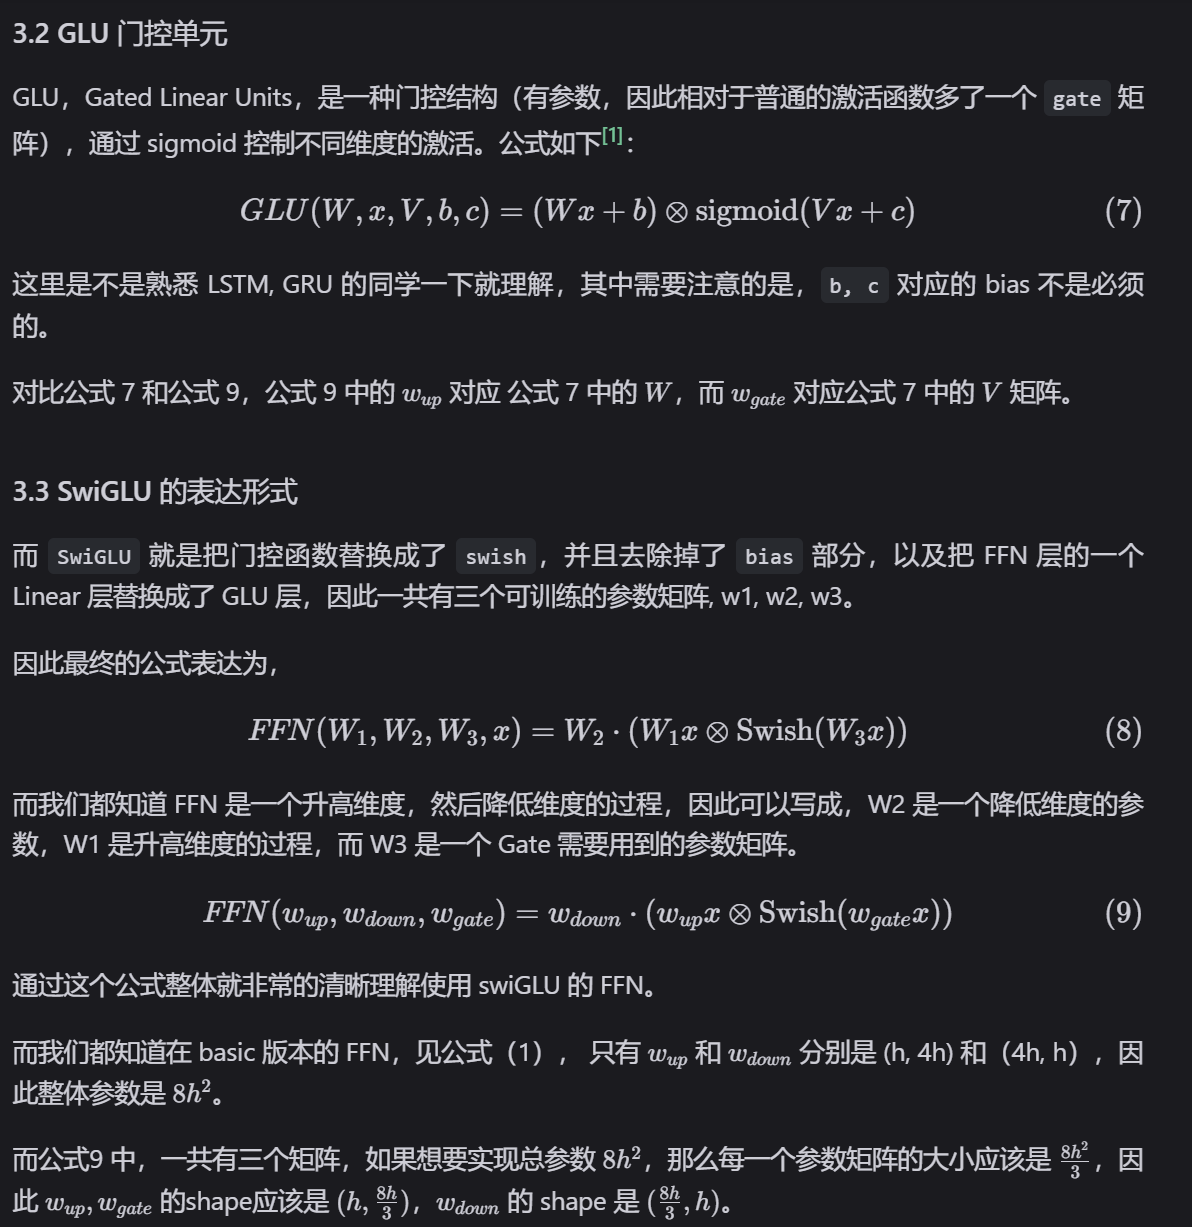

假设输入的 hidden_dim 大小是 hidden_dim，那么中间层（up 后的维度）大小是 mid_dim， 具体计算逻辑如下：

In [3]:
hidden_dim  = 15
mid_dim = int(8 * hidden_dim / 3)
# multiple of：使SwiGLU隐藏层大小为2的大倍数
multiple_of = 256
mid_dim = multiple_of * ((mid_dim + multiple_of - 1) // multiple_of)
# # multiple_of 一般设置为 256， LLaMA 和 GPT等模型
print(mid_dim)

256


注意，在 LLM (大语言模型) 架构中，multiple_of 是一个用于优化计算效率的参数，通常设置为 256 或其他 2 的幂次方数（如 128、512 等），最终让 mid_dim 调整为 multiple_of 的整数倍。这样做有几个原因：

硬件优化：现代 GPU/TPU 在处理 2 的幂次方大小的张量时效率最高
内存对齐：确保内存对齐可以提高计算速度
并行计算效率：某些并行计算操作在处理规整的数字时效率更高

### 带有 swishGLU 的 FFN 代码实现

In [6]:
class FFNExpert(nn.Module):
    def __init__(self, hidden_dim, dropout):
        super().__init__()

        hidden_dim  = hidden_dim
        # 这里可以优化成 multiple_of 的倍数
        mid_dim = hidden_dim * 8//3

        self.up = nn.Linear(hidden_dim, mid_dim, bias=False)
        self.down = nn.Linear(mid_dim, hidden_dim, bias=False)
        self.gate = nn.Linear(hidden_dim, mid_dim, bias = False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        tmp_out = F.silu(
            self.gate(x) 
        ) * self.up(x)
        
        tmp_out = self.down(tmp_out)
        out = self.dropout(tmp_out)
        print(out.shape)
        return out

In [7]:
ffn = FFNExpert(hidden_dim=8, dropout=0.1)
x = torch.randn(4, 5, 8)
ffn(x)

torch.Size([4, 5, 8])


tensor([[[-5.1029e-02, -2.5511e-02, -1.0556e-02,  1.0611e-03, -7.5072e-03,
          -2.2718e-02, -1.4001e-02, -2.2296e-02],
         [ 2.8513e-01,  1.0904e-01, -1.7501e-01,  4.7847e-02, -6.5752e-02,
          -2.9585e-02,  1.1913e-01,  9.2710e-03],
         [ 0.0000e+00,  4.3688e-02, -8.3789e-02, -6.4861e-02,  1.0388e-02,
          -4.6223e-02, -1.8505e-02,  3.7152e-02],
         [-1.1947e-01,  6.9944e-02,  2.0389e-02,  0.0000e+00,  2.3410e-03,
           1.3834e-02,  1.1018e-01, -1.1398e-01],
         [-4.0468e-02,  3.8862e-01, -2.4467e-01, -0.0000e+00, -2.0037e-01,
          -5.0469e-02,  2.6052e-01,  4.8859e-01]],

        [[ 9.4579e-02,  7.7019e-02, -2.8934e-02, -3.7985e-02, -7.5812e-02,
          -0.0000e+00, -6.4029e-02,  3.4996e-02],
         [ 2.4286e-02,  0.0000e+00,  7.7939e-02,  8.7253e-02, -2.9989e-02,
           3.1846e-03,  5.0322e-02,  1.7599e-01],
         [-9.3631e-03,  3.1423e-02,  4.0563e-02,  5.6637e-02,  1.6413e-02,
           3.3869e-03, -3.7701e-02,  7.3898e-02]